In [1]:
# Python Project Template

### 1. Prepare Problem
#### a) Load libraries
#### b) Load dataset

### 2. Summarize Data
#### a) Descriptive statistics
#### b) Data visualizations

### 3. Prepare Data
#### a) Data Cleaning
#### b) Feature Selection
#### c) Data Transform

### 4. Evaluate Algorithms
#### a) Split-out validation dataset
#### b) Test options and evaluation metric
#### c) Spot check Algorithms

### 5. Improve Accuracy
#### a) Algorithm Tuning
#### b) Ensembles

### 6. Finalize Model 
#### a) Predictions on validation dataset
#### b) Create standalone model on entire training dataset
#### c) Save model for later use

### 1. Prepare Problem

#### a) Load libraries

In [2]:
#### a) Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import psutil
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Prevent "UserWarning: raise ValueError(f”found {cpu_count_physical} physical cores < 1″)" in block 26 "Standardize the dataset" for KNN Regressor model
# It did not affect the creation of the model, but the warning appeared every time I ran it, so I got this solution from https://relaxing-living-life.com/1831/

def set_loky_max_cpu_count():
    physical_cores = psutil.cpu_count(logical=False)
    logical_cores = psutil.cpu_count(logical=True)
    cpu_count = max(1, min(physical_cores, logical_cores))
    os.environ['LOKY_MAX_CPU_COUNT'] = str(cpu_count)
    print(f"LOKY_MAX_CPU_COUNT set to {cpu_count}")

set_loky_max_cpu_count()

LOKY_MAX_CPU_COUNT set to 4


#### b) Load dataset

In [4]:
# Get the parent directory of the notebook
notebook_dir = os.path.abspath('')  # This gets the current notebook path
project_root = os.path.dirname(notebook_dir)  # Go one level up if needed

# Change the working directory
os.chdir(project_root)

In [5]:
#### b) Load dataset
df = pd.read_csv("data/intermediate/processed.csv", encoding='cp1252')
print("the dataset has " + str(df.shape[0]) + " observations (ice cream flavors) and " + str(df.shape[1]) + " features " + str([col for col in df.columns]))

the dataset has 241 observations (ice cream flavors) and 5 features ['brand', 'name', 'rating', 'rating_count', 'ingredients_cleaned']


In [6]:
# dataset comments
df

,brand,name,rating,rating_count,ingredients_cleaned
0,BenJerrys,Salted Caramel Core,3.7,208,"cream, skim milk, sugar syrup, water, brown su..."
1,BenJerrys,Netflix & Chilll'd,4.0,127,"cream, skim milk, sugar syrup, water, sugar, p..."
2,BenJerrys,Chip Happens,4.7,130,"cream, sugar syrup, skim milk, water, sugar, c..."
3,BenJerrys,Cannoli,3.6,70,"cream, skim milk, sugar syrup, water, corn syr..."
4,BenJerrys,Gimme Smore!,4.5,281,"cream, skim milk, water, sugar syrup, sugar, c..."
...,...,...,...,...,...
236,Breyers,Cinnabon,4.0,28,"milk, corn syrup, sugar, brown sugar, soybean ..."
237,Breyers,Carbsmart Caramel Swirl Bar,4.7,18,"milk, water, caramel, sugar, corn syrup, milk ..."
238,Breyers,Layered Dessert S'mores,2.5,31,"milk, corn syrup, sugar, wheat flour, butter, ..."
239,Breyers,Layered Dessert Peach Cobbler,3.2,38,"milk, corn syrup, wheat flour, niacin, reduced..."


### 2. Summarize Data

#### a) Descriptive statistics

In [7]:
#### a) Descriptive statistics
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nStatistical Summary:")
print(df.describe())

Dataset Shape: (241, 5)

Data Types:
brand                   object
name                    object
rating                 float64
rating_count             int64
ingredients_cleaned     object
dtype: object

Statistical Summary:
           rating  rating_count
count  241.000000    241.000000
mean     4.223237     90.016598
std      0.620383    111.349449
min      1.200000      2.000000
25%      4.000000     28.000000
50%      4.400000     59.000000
75%      4.700000    112.000000
max      5.000000    983.000000


In [8]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
brand                  0
name                   0
rating                 0
rating_count           0
ingredients_cleaned    0
dtype: int64


#### b) Data visualizations

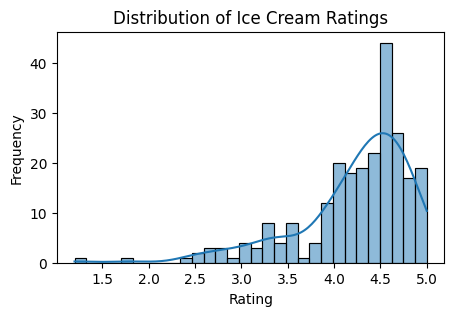

In [9]:
# Distribution of ratings
plt.figure(figsize=(5, 3))
sns.histplot(df['rating'], bins=30, kde=True)
plt.title('Distribution of Ice Cream Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

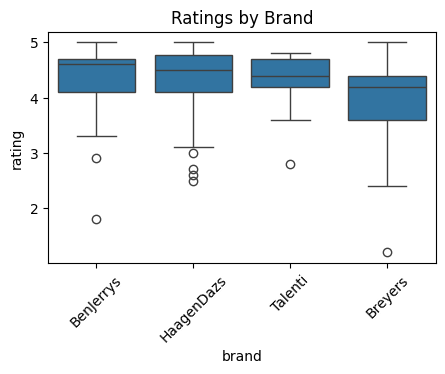

In [10]:
# Ratings by brand
plt.figure(figsize=(5, 3))
sns.boxplot(x='brand', y='rating', data=df)
plt.title('Ratings by Brand')
plt.xticks(rotation=45)
plt.show()

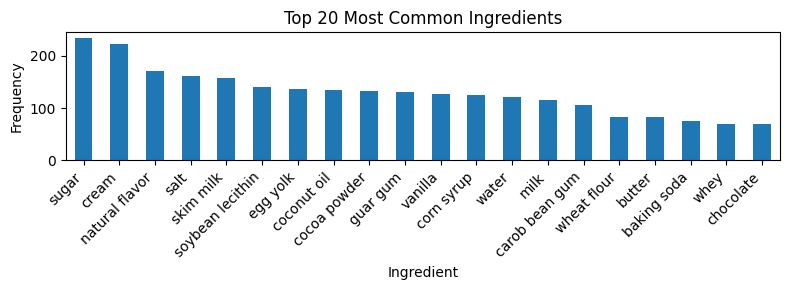

In [11]:
# Ingredient frequency analysis
def count_ingredients(df):
    all_ingredients = []
    for ingredients in df['ingredients_cleaned']:
        all_ingredients.extend([ing.strip() for ing in ingredients.split(',')])
    
    ingredient_counts = pd.Series(all_ingredients).value_counts()
    return ingredient_counts

ingredient_counts = count_ingredients(df)

plt.figure(figsize=(8, 3))
ingredient_counts.head(20).plot(kind='bar')
plt.title('Top 20 Most Common Ingredients')
plt.xlabel('Ingredient')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 3. Prepare Data

#### a) Data Cleaning

In [12]:
# Remove duplicates in ingredients lists
# it was already done in the previous code

#### b) Feature Selection

In [13]:
# We'll use ingredient presence/absence as our primary features
# Convert text ingredients to numerical features
def custom_tokenizer(text):
    return text.split(', ')  # Separates exactly by comma and space

vectorizer = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None)  # Disable default regex
X_ingredients = vectorizer.fit_transform(df['ingredients_cleaned'])
ingredient_names = vectorizer.get_feature_names_out()

In [14]:
# Create DataFrame with ingredient features
X_df = pd.DataFrame(X_ingredients.toarray(), columns=ingredient_names)

In [15]:
# Add brand as a feature (one-hot encoded)
X_brand = pd.get_dummies(df['brand'], prefix='brand').astype(int)
X = pd.concat([X_df, X_brand], axis=1)
X

,acesulfame potassium,almond extract,almond milk,almonds,apple,artificial color,artificial flavor,ascorbic acid,baking powder,baking soda,...,wheat graham flour,whey,whiskey,wine,xanthan gum,yeast extract,brand_BenJerrys,brand_Breyers,brand_HaagenDazs,brand_Talenti
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
237,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
238,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
239,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [21]:
# Salvar as colunas em um arquivo usando joblib
joblib.dump(X.columns, os.path.join(project_root, 'data', 'model', 'colunas_modelo.joblib'))
X.columns

Index(['acesulfame potassium', 'almond extract', 'almond milk', 'almonds',
       'apple', 'artificial color', 'artificial flavor', 'ascorbic acid',
       'baking powder', 'baking soda',
       ...
       'wheat graham flour', 'whey', 'whiskey', 'wine', 'xanthan gum',
       'yeast extract', 'brand_BenJerrys', 'brand_Breyers', 'brand_HaagenDazs',
       'brand_Talenti'],
      dtype='object', length=203)

In [17]:
# Target variable
y = df['rating']
y

0      3.7
1      4.0
2      4.7
3      3.6
4      4.5
      ... 
236    4.0
237    4.7
238    2.5
239    3.2
240    2.8
Name: rating, Length: 241, dtype: float64

#### c) Data Transform

In [19]:
#### c) Data Transformation
# Data is already transformed via CountVectorizer

### 4. Evaluate Algorithms

#### a) Split-out validation dataset

In [ ]:
#### a) Split-out validation dataset
# Split the data
validation_size = 0.2
seed = 7
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)

#### b) Test options and evaluation metric

In [ ]:
#### b) Test options and evaluation metric
n_splits = 10
scoring = 'neg_mean_squared_error'

#### c) Spot check Algorithms

In [ ]:
#### c) Spot check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR(gamma='scale')))

In [ ]:
# evaluate each model
results = []
names = []

print("\nModel Evaluation (Unscaled):")
for name, model in models:
    kfold = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
# compare algorithms with a boxplot
plt.figure(figsize=(5, 4))
plt.title('Algorithm Comparison (Unscaled)')
plt.boxplot(results)
plt.xticks(range(1, len(names) + 1), names)
plt.ylabel('Negative Mean Squared Error')
plt.show()

- The criterion we are using to evaluate the models is "neg_mean_squared_error" (negative mean squared error). Since MSE (Mean Squared Error) measures the error squared, lower values (or less negative ones) indicate a better model.

- SVR achieved the lowest mean error: -0.333735, indicating more accurate predictions. Additionally, it has the lowest standard deviation (0.167837), meaning it is more stable across different dataset splits.

<br>

Next Steps:
- Test data scaling (StandardScaler or MinMaxScaler), as SVR can be sensitive to it.
- Tune SVR hyperparameters to see if performance improves.

In [ ]:
# Standardize the dataset
pipelines = []
pipelines.append(('Scaled_LR', Pipeline([('Scaler', StandardScaler()), ('LR', LinearRegression())])))
pipelines.append(('Scaled_LASSO', Pipeline([('Scaler', StandardScaler()), ('LASSO', Lasso())])))
pipelines.append(('Scaled_EN', Pipeline([('Scaler', StandardScaler()), ('EN', ElasticNet())])))
pipelines.append(('Scaled_KNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsRegressor())])))
pipelines.append(('Scaled_CART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeRegressor())])))
pipelines.append(('Scaled_SVR', Pipeline([('Scaler', StandardScaler()), ('SVR', SVR(gamma='scale'))])))

In [ ]:
# evaluate each scaled model
scaled_results = []
scaled_names = []

print("\nModel Evaluation (Scaled):")
for name, model in pipelines:
    kfold = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    scaled_results.append(cv_results)
    scaled_names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
# compare algorithms
plt.figure(figsize=(5, 4))
plt.title('Scaled Algorithm Comparison')
plt.boxplot(scaled_results)
plt.xticks(range(1, len(scaled_names) + 1), scaled_names, rotation=45)
plt.ylabel('Negative Mean Squared Error')
plt.tight_layout()
plt.show()

#### b) Ensembles

In [ ]:
# Try ensemble methods
ensembles = []
ensembles.append(('Scaled_RF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestRegressor(n_estimators=100))])))
ensembles.append(('Scaled_GBM', Pipeline([('Scaler', StandardScaler()), ('GBM', GradientBoostingRegressor())])))
ensembles.append(('Scaled_ET', Pipeline([('Scaler', StandardScaler()), ('ET', ExtraTreesRegressor(n_estimators=100))])))
ensembles.append(('Scaled_AB', Pipeline([('Scaler', StandardScaler()), ('AB', AdaBoostRegressor())])))

In [ ]:
# evaluate each ensemble
ensemble_results = []
ensemble_names = []

print("\nEnsemble Methods Evaluation:")
for name, model in ensembles:
    kfold = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    ensemble_results.append(cv_results)
    ensemble_names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
# Compare ensemble algorithms
plt.figure(figsize=(5, 3))
plt.title('Ensemble Method Comparison')
plt.boxplot(ensemble_results)
plt.xticks(range(1, len(ensemble_names) + 1), ensemble_names, rotation=45)
plt.ylabel('Negative Mean Squared Error')
plt.tight_layout()
plt.show()

StandardScaler brought a slight improvement in SVR, which continues to be the best model (slightly smaller standard error and deviation). The ensemble methods did not improve the performance, and Scaled SVR remains the best model. Since none of the ensemble models outperformed SVR in terms of mean error, and the stability improvement in GBM is minimal, SVR (with scaling) remains the best choice.

- Before: -0.333735 (0.167837)
- StandardScaler: -0.332875 (0.163132)
- Best ensemble model (GBM): -0.366965 (0.158613)

<br> 

KNN performed slightly worse, but the other models were virtually unchanged. This suggests that data standardization did not have a strong impact, probably because the models (except SVR and KNN) were already less sensitive to scale.

### 5. Improve Accuracy

#### a) Algorithm Tuning

In [ ]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

# Define parameter grid for SVR
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

model = SVR()
kfold = KFold(n_splits=n_splits, random_state=seed, shuffle=True)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1, verbose=2)
grid_result = grid.fit(rescaledX, y_train)

# Print the best parameters
print("\nBest Parameters for SVR:")
print(grid.best_params_)

# Best estimator performance
best_svr = grid.best_estimator_

# Evaluate the best model
y_pred = best_svr.predict(rescaledX)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred)

print("\nBest SVR Model Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

In [ ]:
# Detailed Parameter Grid Results
# Convert results to a more readable DataFrame
results_df = pd.DataFrame(grid.cv_results_)
results_df

In [ ]:
# Select and display most relevant columns
display_columns = [
    'param_kernel', 
    'param_C', 
    'param_epsilon', 
    'param_gamma', 
    'mean_test_score', 
    'std_test_score'
]

# Sort by best performance
results_summary = results_df[display_columns].sort_values('mean_test_score', ascending=False)
print("\nTop 10 Parameter Combinations:")
print(results_summary.head(10))

In [ ]:
# Residual Analysis for Best SVR Model
# Predict on validation set
X_validation_scaled = scaler.transform(X_validation)
y_pred_validation = best_svr.predict(X_validation_scaled)

In [ ]:
# Residual Plot
plt.figure(figsize=(10, 6))
residuals = y_validation - y_pred_validation
plt.scatter(y_pred_validation, residuals)
plt.title('Residual Plot for Best SVR Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [ ]:
# Q-Q Plot of Residuals
from scipy import stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

In [ ]:
# Compute permutation importance
perm_importance = permutation_importance(
    best_svr, 
    rescaledX,  # Use scaled features
    y_train, 
    n_repeats=10,  # Number of times to permute each feature
    random_state=42
)

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 6))
top_features = importance_df.head(15)
sns.barplot(
    x='importance', 
    y='feature', 
    data=top_features, 
    color='skyblue'  # Set a base color
)

# Add error bars manually
plt.errorbar(
    x=top_features['importance'], 
    y=top_features['feature'], 
    xerr=top_features['std'], 
    fmt='none',  # No line connecting points
    color='black',  # Error bar color
    capsize=5  # Caps on error bars
)

plt.title('Top 15 Most Important Features for SVR (Permutation Importance)')
plt.xlabel('Permutation Importance')
plt.tight_layout()
plt.show()

In [ ]:
importance_df

##### Permutation Importance:
- Measures how much the model's performance decreases when a feature is randomly shuffled.
- A higher importance value means the feature is more critical to the model's predictions.

- There are the most important features. These features have the largest impact on the model's predictions. If their values are shuffled, the model's performance decreases the most.

- Rice flour is the most important feature, with an importance score of 0.0411. This means that shuffling its values reduces the model's performance by about 4.11% on average. Its low standard deviation (0.0088) suggests this contribution is stable.

- Vitamin a palmitate is the second most important feature, but its higher standard deviation (0.0117) indicates its importance is less consistent across shuffles. This could be due to interactions with other features or noise in the data.

### 6. Finalize Model

#### a) Create a function to predict ratings for new ice creams

In [ ]:
#### a) Create a function to predict ratings for new ice creams
def predict_rating(brand, ingredients):
    """
    Predict the rating of a new ice cream based on brand and ingredients.
    
    Parameters:
    brand (str): The brand of the ice cream
    ingredients (str): Comma-separated list of ingredients
    
    Returns:
    float: Predicted rating (1-5 scale)
    """

    

    # Create a new dataframe with one row
    new_data = pd.DataFrame({
        'brand': [brand],
        'ingredients_cleaned': [df['ingredients_cleaned']]
    })
    
    # Transform ingredients
    X_ingredients_new = vectorizer.transform(new_data['ingredients_cleaned'])
    X_df_new = pd.DataFrame(X_ingredients_new.toarray(), columns=ingredient_names)
    
    # One-hot encode brand
    # First, create a DataFrame with all brands set to 0
    brand_cols = [col for col in X.columns if col.startswith('brand_')]
    X_brand_new = pd.DataFrame(0, index=range(1), columns=brand_cols)
    
    # Set the specific brand to 1 if it exists in the training data
    brand_col = f'brand_{brand}'
    if brand_col in X_brand_new.columns:
        X_brand_new[brand_col] = 1
    
    # Combine features
    X_new = pd.concat([X_df_new, X_brand_new], axis=1)
    
    # Make sure all columns from training exist (fill missing with 0)
    for col in X.columns:
        if col not in X_new.columns:
            X_new[col] = 0
    
    # Ensure columns are in the same order
    X_new = X_new.reindex(columns=X.columns, fill_value=0)
    
    # Predict
    predicted_rating = best_model.predict(X_new)[0]
    return predicted_rating

In [ ]:
# Test the prediction function with a new ice cream
new_brand = "Ben & Jerry's"
new_ingredients = "cream, milk, sugar, egg yolks, vanilla extract, chocolate chips, cookie dough"
predicted = predict_rating(new_brand, new_ingredients)
print(f"\nPredicted rating for {new_brand} ice cream with ingredients: {new_ingredients}")
print(f"Predicted Rating: {predicted:.2f}/5.0")

# Compare a few more examples to see how different ingredients affect ratings
test_cases = [
    ("Haagen-Dazs", "cream, milk, sugar, egg yolks, vanilla bean"),
    ("Breyers", "milk, cream, sugar, strawberry, natural flavor"),
    ("Talenti", "milk, sugar, cream, chocolate, coffee, cocoa powder"),
    ("Blue Bell", "milk, cream, sugar, cookie pieces, caramel, salt")
]

print("\nComparing Different Ice Cream Formulations:")
for brand, ingredients in test_cases:
    rating = predict_rating(brand, ingredients)
    print(f"{brand} with {ingredients}: {rating:.2f}/5.0")

In [ ]:
import joblib

# Save the best SVR model
joblib.dump(best_svr, 'best_svr_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

In [ ]:
hasattr(model, 'support_vectors_')

In [ ]:
datatest = pd.DataFrame(best_svr)
datatest

#### b) Save model for later use

In [ ]:
# Save the best SVR model
joblib.dump(best_svr, os.path.join(project_root, 'data', 'model', 'best_svr_model.joblib'))
joblib.dump(best_svr, os.path.join(project_root, 'data', 'model', 'best_svr_model.pkl'))

# Save the scaler for preprocessing future data
joblib.dump(scaler, os.path.join(project_root, 'data', 'model', 'svr_scaler.joblib'))
joblib.dump(scaler, os.path.join(project_root, 'data', 'model', 'svr_scaler.pkl'))

print("\nBest SVR model and scaler saved successfully!")

# testes para utils, apagar depois

In [ ]:
# Load the model and scaler
best_svr = joblib.load(os.path.join(project_root, 'data', 'model', 'best_svr_model.pkl'))
scaler = joblib.load(os.path.join(project_root, 'data', 'model', 'svr_scaler.pkl'))

In [ ]:

def predict_rating(ingredients):
    """
    Predicts the rating based on given ingredients.
    
    Args:
        ingredients (list): A list of ingredient values (in the same order as X_train columns).
    
    Returns:
        float: Predicted rating.
    """
    # Convert ingredients to a numpy array and reshape for scaling
    ingredients_array = np.array(ingredients).reshape(1, -1)
    
    # Scale the ingredients using the saved scaler
    scaled_ingredients = scaler.transform(ingredients_array)
    
    # Predict the rating using the SVR model
    predicted_rating = best_svr.predict(scaled_ingredients)
    
    return predicted_rating[0]  # Return the first (and only) prediction